<a href="https://colab.research.google.com/github/Vaish2511/Classifying-Pneumonia/blob/main/Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import random
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Activation, MaxPooling2D, AveragePooling2D, Dense, concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [2]:
from google.colab import files

In [3]:
!cp '/content/drive/MyDrive/DIP/kaggle.json' '/content'

In [4]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [7]:
len(os.listdir('/tmp'))

33

In [8]:
main_dir = "/tmp/chest_xray"
train_data_dir = main_dir + "/train"
validation_data_dir = main_dir + "/val"
test_data_dir = main_dir + "/test"

nb_train_samples = 5216
nb_validation_samples = 16
epochs = 10
batch_size = 64

print("Working Directory Contents:", os.listdir(main_dir))
print("Working Directory Contents:", len(os.listdir(train_data_dir)))

Working Directory Contents: ['test', '__MACOSX', 'train', 'val', 'chest_xray']
Working Directory Contents: 2


In [9]:
train_data = glob.glob('/tmp/chest_xray/train/**/*.jpeg')
len(train_data)

5216

In [10]:
test_data = glob.glob('/tmp/chest_xray/test/**/*.jpeg')
len(test_data)

624

In [11]:
val_data = glob.glob('/tmp/chest_xray/val/**/*.jpeg')
len(val_data)

16

In [12]:
DIR = main_dir
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for i in sets:
    path = os.path.join(DIR, i)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")

Total Pneumonia Images: 4273
Total Normal Images: 1583


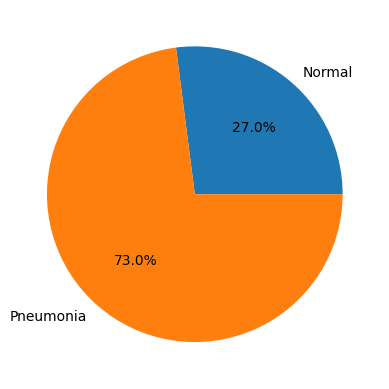

In [13]:
label = ['Normal', 'Pneumonia']
plt.pie([len(all_normal), len(all_pneumonia)],
        labels=label,
        autopct='%1.1f%%');

Shuffle Images Randomly

In [14]:
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]
len(images)

100

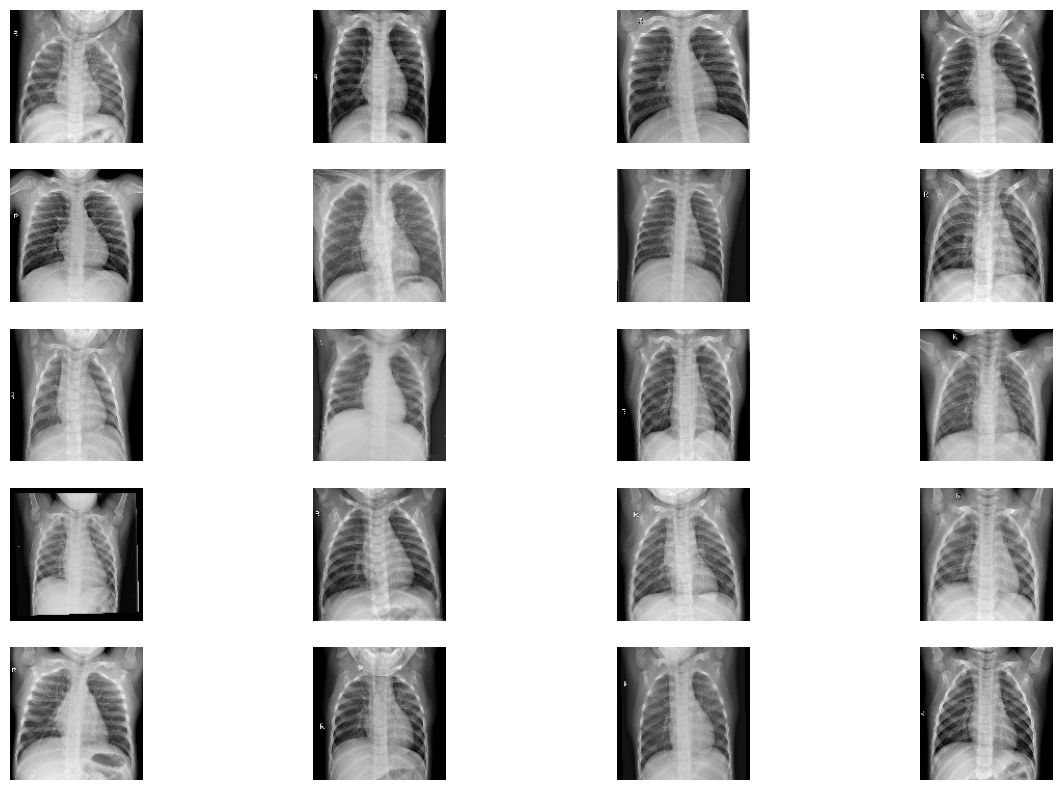

In [15]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 5
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

Gaussian Blur

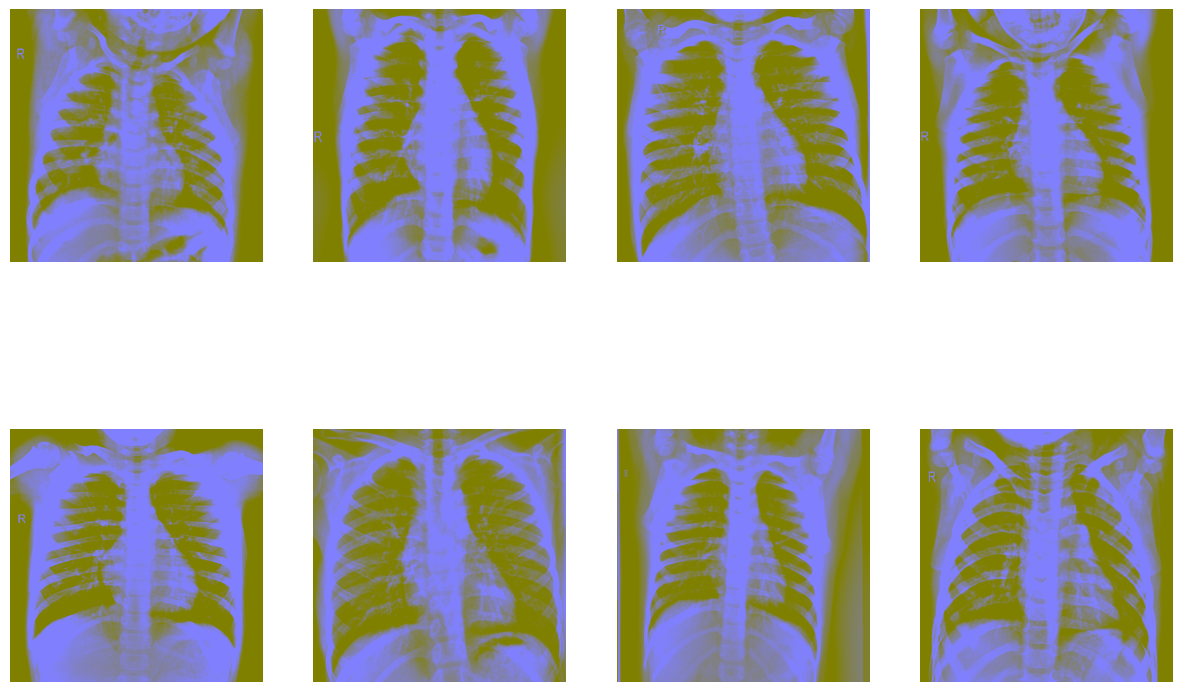

In [16]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

Fourier Transform

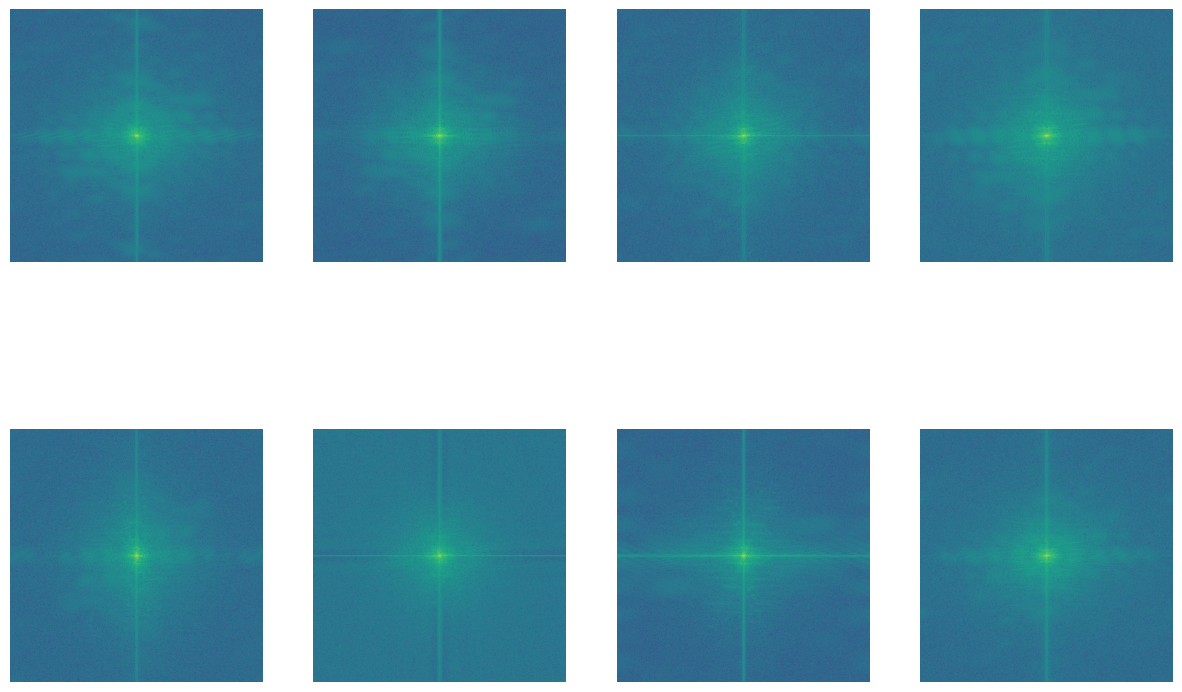

In [17]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fig.add_subplot(rows, columns, i)
    plt.imshow(magnitude_spectrum)
    plt.axis(False)

Image Erosion

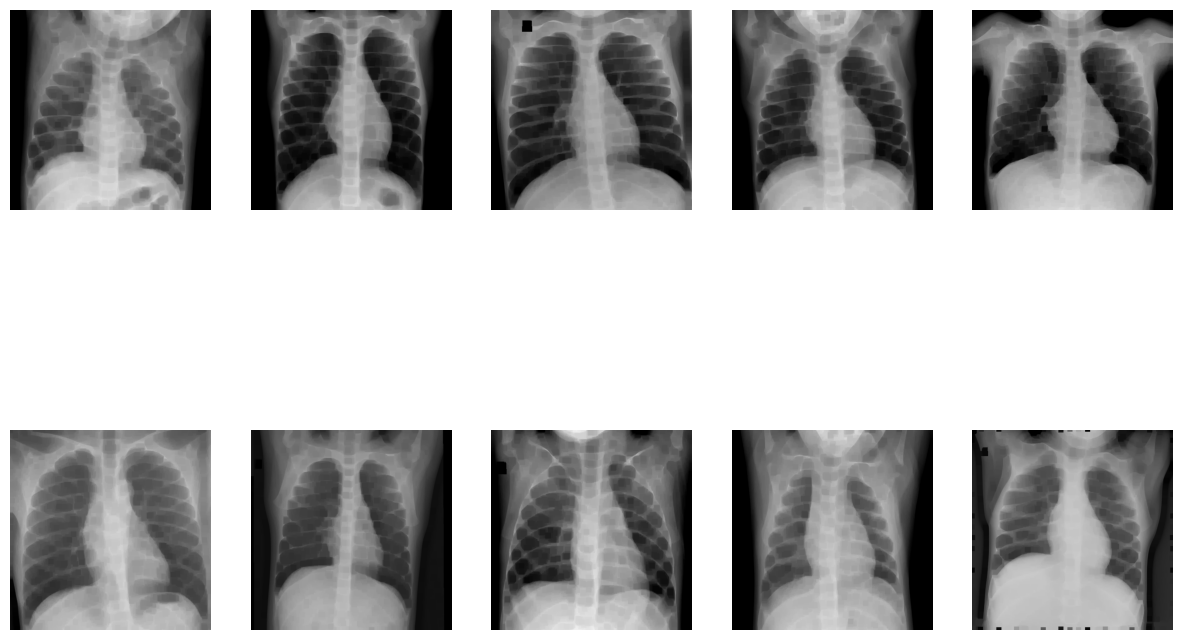

In [18]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

Image Dilation

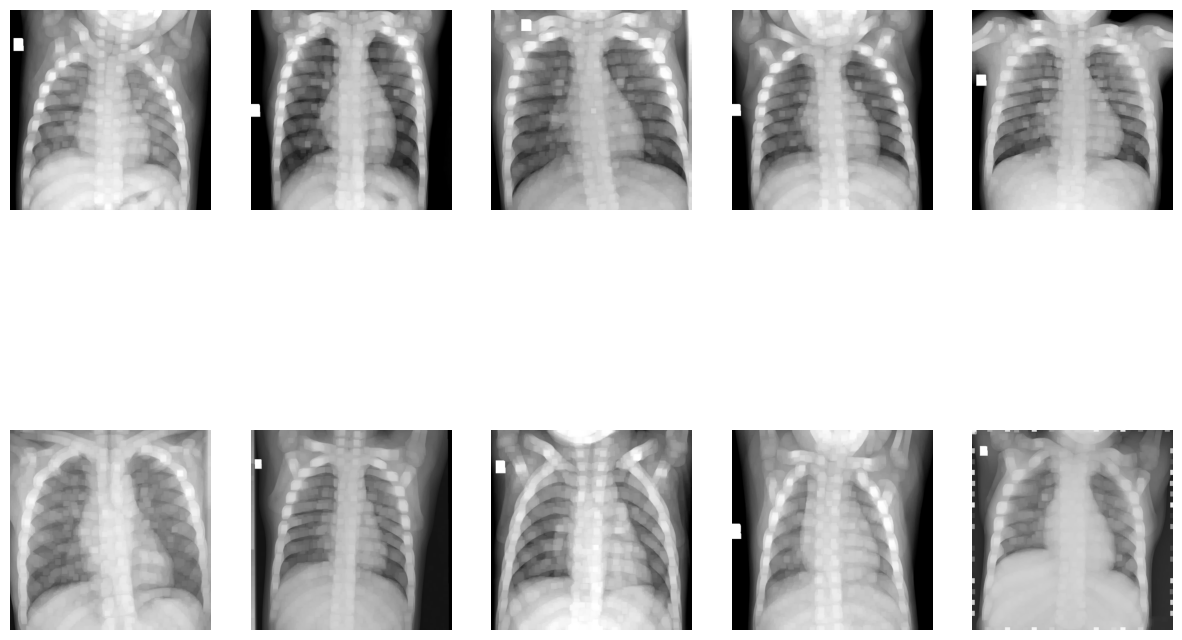

In [19]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

Edge Detection

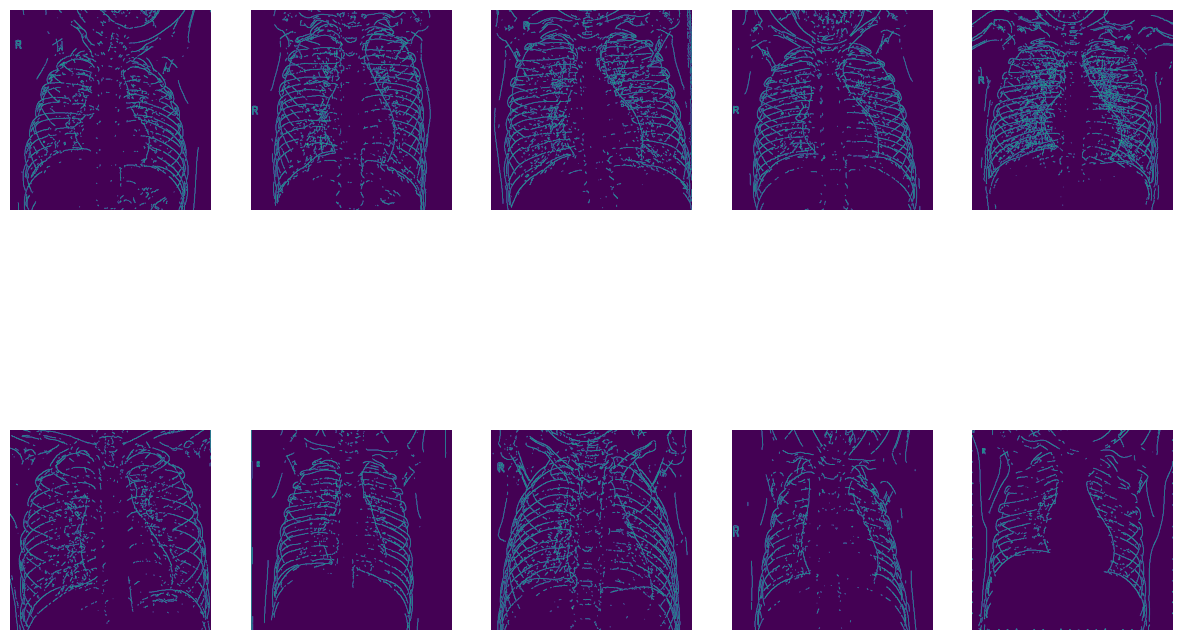

In [20]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)

In [21]:
img_height, img_width  = 180, 180

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Data Augmentation

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [23]:
from tensorflow.keras import layers, models, optimizers

# Model Definition
input_shape = (150, 150, 3)  # Adjust as per your input size

model = models.Sequential()

# First Conv Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Conv Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Conv Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed them into a Dense layer
model.add(layers.Flatten())

# Add Dense Layer with 64 units
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()
model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,327,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,355,873 (5.17 MB)

 Trainable params: 1,355,873 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
metrics = [tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name = "recall")]

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = metrics)

In [25]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights = True)

In [26]:
count_normal = len(all_normal)
count_pneumonia = len(all_pneumonia)

initial_bias = count_pneumonia / count_normal
print("Initial bias: {:.5f}".format(initial_bias))

TRAIN_IMG_COUNT = count_normal + count_pneumonia
weight_for_0 = (1 / count_normal) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / count_pneumonia) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 2.69931
Weight for class 0: 1.85
Weight for class 1: 0.69


In [27]:
history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks = [early_stopping_cb],
    verbose = 1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - binary_accuracy: 0.7031 - loss: 0.6091 - precision: 0.7359 - recall: 0.9287 - val_binary_accuracy: 0.5000 - val_loss: 0.7368 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - binary_accuracy: 0.7504 - loss: 0.4132 - precision: 0.7506 - recall: 0.9982 - val_binary_accuracy: 0.5000 - val_loss: 1.0994 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - binary_accuracy: 0.8292 - loss: 0.3859 - precision: 0.8537 - recall: 0.9330 - val_binary_accuracy: 0.7500 - val_loss: 0.7432 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - binary_accuracy: 0.8484 - loss: 0.3524 - precision: 0.8895 - recall: 0.9090 - val_binary_accuracy: 0.8125 - val_loss: 0.7826 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - binary_accuracy: 0.8668 - loss: 0.3189 - precision: 0.9129 - recal

In [28]:
from keras.models import load_model
model.save('chestxray_cnn_model.h5')
from tensorflow import keras

In [29]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image(filename):
    # Load the image and resize it to (150, 150)
    img = load_img(filename, target_size=(150, 150))  # Resize to match model's input shape
    image = img_to_array(img)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = image.reshape(1, 150, 150, 3)  # Reshape to (1, 150, 150, 3)

    # Make a prediction
    prediction = model.predict(image)

    # Interpret the prediction
    if prediction[0] > 0.5:
        stat = prediction[0] * 100
        print(f"This image is %.2f percent %s" % (stat, "PNEUMONIA"))
    else:
        stat = (1.0 - prediction[0]) * 100
        print("This image is %.2f percent %s" % (stat, "NORMAL"))

# Example usage
predict_image("/tmp/chest_xray/train/NORMAL/IM-0117-0001.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
This image is 77.84 percent NORMAL


<ipython-input-29-a0e58cc5fd68>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("This image is %.2f percent %s" % (stat, "NORMAL"))


Addressing class imbalance using GANs

In [30]:
# Generator Model
def build_generator(latent_dim):
    model = Sequential()
    model.add(layers.Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
    model.add(layers.Reshape((8, 8, 128)))  # Reshape into 8x8x128 feature map
    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu"))
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu"))
    model.add(layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu"))
    model.add(layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="tanh"))
    return model

In [31]:
# Discriminator Model
def build_discriminator(img_shape):
    model = Sequential()
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same", input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

In [32]:
# GAN Model (Combines Generator and Discriminator)
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [33]:
# Initialize and compile the models
latent_dim = 100  # Dimension of the random noise vector (latent space)
img_shape = (128, 128, 3)  # Image dimensions (same as in your pre-processing)

# Create generator and discriminator
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)

# Compile the discriminator
discriminator.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [34]:
# Create GAN (Generator + Discriminator)
gan = build_gan(generator, discriminator)
gan.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

In [35]:
train_data = np.array(train_data)  # Convert to NumPy array

In [ ]:
import numpy as np
import cv2

def train_gan(epochs, batch_size, train_data):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train Discriminator: Real images
        idx = np.random.randint(0, len(train_data), half_batch)  # Generate random indices
        real_images = []
        for i in idx:
            img = cv2.imread(train_data[i])  # Load image
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize image to (128, 128)
                real_images.append(img)
            else:
                print(f"Warning: Unable to load image at index {i}")

        real_images = np.array(real_images)  # Convert list to NumPy array
        real_images = real_images.astype(np.float32) / 255.0  # Normalize images

        # Train Discriminator: Fake images
        noise = np.random.normal(0, 1, (half_batch, 100))  # Generate random noise
        fake_images = generator.predict(noise)  # Generate fake images using the generator

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))  # Generate random noise
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

# Example usage
train_gan(epochs=5000, batch_size=64, train_data=all_normal)  # Assuming `all_normal` contains normal images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch: 0, D Loss: 0.673696756362915, G Loss: [array(0.68033814, dtype=float32), array(0.68033814, dtype=float32), array(0.515625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 